In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [2]:
# load data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_train = X_train.iloc[:,1:]
y_train = y_train.iloc[:,1:]

In [3]:
X = np.array(X_train)
y = np.array(y_train).reshape(y_train.shape[0],1)
X.shape

(18859, 8)

In [4]:
n = X.shape[0]
# add intercept 
X = np.concatenate((np.array([1]*n).reshape(n,1), X),axis=1)
# add interaction terms
X_interaction = X.copy()
for i in range(1,X.shape[1]-1):
    for j in range(i+1,X.shape[1]):
        X_interaction = np.concatenate((X_interaction, X[:,i].reshape(n,1)*X[:,j].reshape(n,1)), axis=1)
X_interaction = np.concatenate((X_interaction, X[:,[1,3,6]]**2),axis=1)
X_interaction.shape

(18859, 40)

In [5]:
X = X_interaction
np.linalg.matrix_rank(X)

38

In [6]:
def singular_index(X):
    index = np.arange(X.shape[1])
    ans = []
    p = X.shape[1]
    for i in range(p-1,-1,-1):
        if np.linalg.matrix_rank(X[:,index != i]) == np.linalg.matrix_rank(X):
            ans.append(i)
    return ans

def index_to_remove(X):
    remove_index = []
    index = np.arange(X.shape[1])
    rank = np.linalg.matrix_rank(X)
    for i in singular_index(X):
        if np.linalg.matrix_rank(X[:, (index != i) & (~np.isin(index, remove_index))]) == rank:
            remove_index.append(i)
    return remove_index

## Model Selection

In [7]:
# number pf rows is too large to run, randomly pick 10% data to run
np.random.seed(551)
selected_row = np.random.choice(np.arange(X.shape[0]),size=n//10)
X = X[selected_row,:]
y = y[selected_row,:]
n = n//10

In [8]:
np.linalg.matrix_rank(X)

35

In [9]:
remove_index = index_to_remove(X)
remove_index

[37, 33, 27, 18, 17]

In [10]:
X = X[:,~np.isin(np.arange(X.shape[1]), index_to_remove(X))]

In [11]:
# compute marginal probability
def log_marginal_prob(y, X):
    n = X.shape[0]
    p = X.shape[1]
    g = n
    nu0=1
    if p == 0:
        SSR_g = y.T@y
        sigma0_square = np.mean(y**2)
    else:
        sigma0_square = y.T@(np.identity(n)-X@np.linalg.inv(X.T@X)@X.T)@y/(n-p)
        SSR_g = y.T@(np.identity(n)-g/(g+1)*X@np.linalg.inv(X.T@X)@X.T)@y
    part1 = -0.5*(n*np.log(np.pi)+p*np.log(1+g)+(nu0+n)*np.log(nu0*sigma0_square+SSR_g)-nu0*np.log(nu0*sigma0_square))
    part2 = scipy.special.loggamma((nu0+n)/2)-scipy.special.loggamma(nu0/2)
    return part1[0,0]+part2, sigma0_square, SSR_g

In [12]:
# MCMC
n = X.shape[0]
# starting point
nu0=1
z = np.array([1]*X.shape[1])
marg_prob_curr = log_marginal_prob(y, X[:,z==1])[0]
S = 2000
Z = np.empty((S,X.shape[1]))
Z[:] = np.nan
sigma_square = np.zeros((S,1))
beta = np.zeros((S,X.shape[1]))
g = n

for s in range(S):
    index = np.arange(X.shape[1])
    np.random.shuffle(index)
    for j in index:
        zp = z.copy()
        zp[j] = 1-zp[j]  
        marg_prob_prop = log_marginal_prob(y, X[:,zp==1])[0]
        r = (marg_prob_prop-marg_prob_curr)*(-1)**(zp[j]==0)
        z[j] = np.random.binomial(n=1,p=scipy.special.expit(r),size=1)
        if z[j] == zp[j]:
            marg_prob_curr = marg_prob_prop
    Z[s,:] = z.copy()
    _, sigma0_square, ssr_g = log_marginal_prob(y, X[:,z==1])
    shape, scale = (nu0+n)/2, 1/((nu0*sigma0_square+ssr_g)/2)[0,0]
    sigma_square[s] = 1/(np.random.gamma(shape, scale, 1))
    beta_ols = np.linalg.inv(X[:,z==1].T@X[:,z==1])@X[:,z==1].T@y
    cov=g/(g+1)*sigma_square[s]*np.linalg.inv(X[:,z==1].T@X[:,z==1])
    beta[s,z==1] = np.random.multivariate_normal(mean=g/(g+1)*beta_ols[:,0], 
                                              cov=cov, 
                                              size=1)

/var/folders/pm/vl21_lpn2kgb1mwypv53ww2r0000gn/T/ipykernel_83480/2803735925.py:31: RuntimeWarning: covariance is not positive-semidefinite.
  beta[s,z==1] = np.random.multivariate_normal(mean=g/(g+1)*beta_ols[:,0],


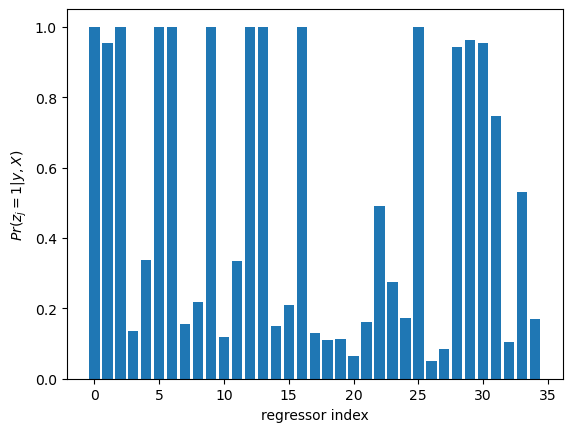

In [13]:
pz = np.sum(Z,axis=0)/S
plt.bar(np.arange(pz.shape[0]),pz)
plt.xlabel('regressor index')
plt.ylabel(r'$Pr(z_j=1 | y, X)$')
plt.show()

In [14]:
#save metrics
np.savetxt("Z.txt",Z)
np.savetxt("beta.txt",beta)
np.savetxt("sigma_square.txt",sigma_square)

In [15]:
# load test data
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
X_test = X_test.iloc[:,1:]
y_test = y_test.iloc[:,1:]

In [16]:
# make prediction
beta_bma = np.mean(beta,axis=0).reshape(X.shape[1],1)
X_test = np.array(X_test)
y_test = np.array(y_test)
n_test = X_test.shape[0]
# add intercept 
X_test = np.concatenate((np.array([1]*n_test).reshape(n_test,1), X_test),axis=1)
# add interaction terms
X_interaction = X_test.copy()
for i in range(1,X_test.shape[1]-1):
    for j in range(i+1,X_test.shape[1]):
        X_interaction = np.concatenate((X_interaction, X_test[:,i].reshape(n_test,1)*X_test[:,j].reshape(n_test,1)), 
                                       axis=1)
X_interaction = np.concatenate((X_interaction, X_test[:,[1,3,6]]**2),axis=1)
X_interaction.shape

(4715, 40)

In [17]:
# root mean square error
X_test = X_interaction
X_test = X_test[:,~np.isin(np.arange(X_test.shape[1]), remove_index)]
y_test_pred = X_test@beta_bma
np.sqrt(np.sum((y_test-y_test_pred)**2)/n_test)

45.320541359621345

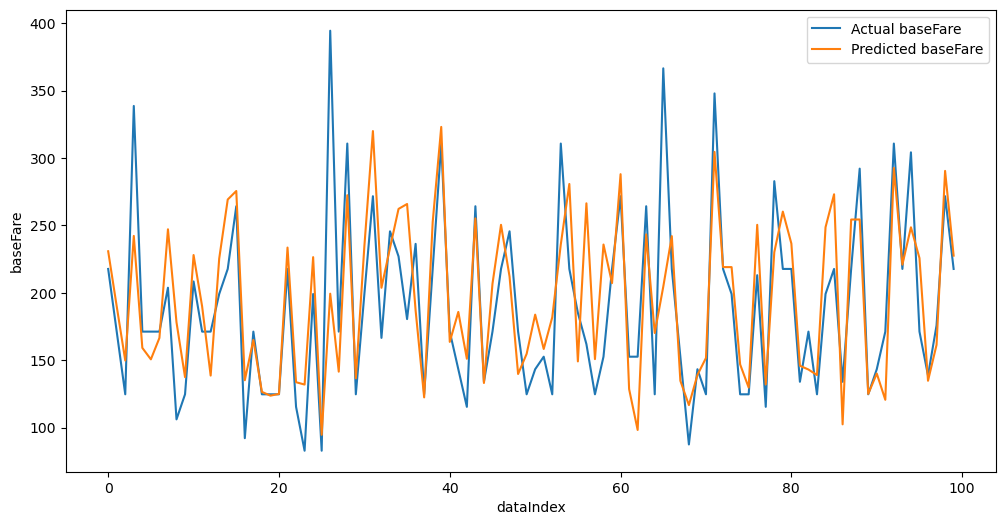

In [18]:
# plot the first 100 data points
plt.figure(figsize=[12,6])
plt.plot(np.arange(100),y_test[:100],label='Actual baseFare')
plt.plot(np.arange(100),y_test_pred[:100],label='Predicted baseFare')
plt.xlabel('dataIndex')
plt.ylabel('baseFare')
plt.legend()
plt.show()